<a href="https://colab.research.google.com/github/edwin-19/Knowledge-Graph/blob/main/Spacy_KG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install networkx
!pip install spacy
!pip install gdown

In [29]:
import gdown
import networkx as nx
import spacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

import pandas as pd
import os
from wordcloud import WordCloud
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from typing import List

# Download data & load spacy model

In [10]:
if not os.path.exists('data/wiki_sentences_v2.csv'):
  os.makedirs('data', exist_ok=True)
  url = 'https://drive.google.com/uc?id=1YzZNETLRsZqN4tN_8xb8as3ICcFGlFo_'
  gdown.download(url, 'data/wiki_sentences_v2.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1YzZNETLRsZqN4tN_8xb8as3ICcFGlFo_
To: /content/data/wiki_sentences_v2.csv
100%|██████████| 275k/275k [00:00<00:00, 45.4MB/s]


In [13]:
# Load spacy model
nlp = spacy.load('en_core_web_sm')

# Simple testing to see if it works
doc = nlp('This 22 year old he recently won the state cup')
for tok in doc:
  print(tok.text, '...', tok.dep_)

This ... det
22 ... nummod
year ... npadvmod
old ... advmod
he ... nsubj
recently ... advmod
won ... ROOT
the ... det
state ... compound
cup ... dobj


In [11]:
df = pd.read_csv('data/wiki_sentences_v2.csv')

In [12]:
df.head()

,sentence
0,"confused and frustrated, connie decides to lea..."
1,"later, a woman’s scream is heard in the distance."
2,christian is then paralyzed by an elder.
3,the temple is set on fire.
4,"outside, the cult wails with him."


In [15]:
df.shape

(4318, 1)

# Extract Entities and relations

In [24]:
def get_entities(sent: str) -> List[str]:
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == 'compound':
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  
  return [ent1.strip(), ent2.strip()]

get_entities(df['sentence'].sample(1).iloc[0])

['even  boredom', 'him']

In [25]:
def get_relation(sent):
  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add('matching_1', None, pattern)
  matches = matcher(doc)

  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [26]:
entity_pairs = []
for sent in tqdm(df['sentence']):
  entity_pairs.append(get_entities(sent))

  0%|          | 0/4318 [00:00<?, ?it/s]

In [28]:
relations = []
for ent in tqdm(df['sentence']):
  relations.append(get_relation(ent))

  0%|          | 0/4318 [00:00<?, ?it/s]

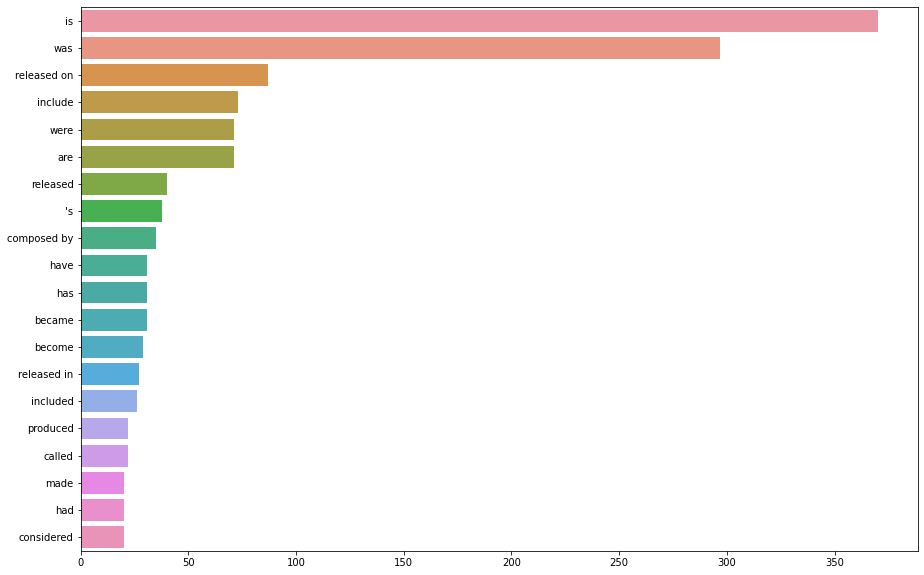

In [39]:
# Take a look at the top 20 relations
data = pd.Series(relations).value_counts()[:20]
plt.figure(figsize=(15, 10))
sns.barplot(y=list(data.keys()), x=data.values)

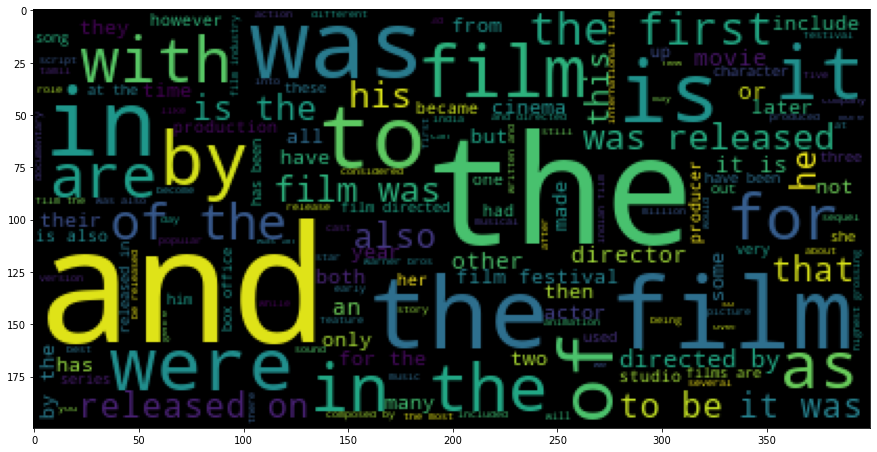

In [43]:
# Lets visualize the words and see the word dist
cloud = WordCloud(stopwords='eng').generate(' '.join(df['sentence']))
plt.figure(figsize=(15, 10))
plt.imshow(cloud)

# Lets build our knowldege graph

In [44]:
source = [i[0] for i in entity_pairs]
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({
    'source':source, 'target':target, 'edge':relations
})

In [45]:
kg_df.head(10)

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with
5,it,religious awakening,'s
6,c. mackenzie,craig cast,joined
7,later craig di francia,action cast,revealed
8,sebastian maniscalco,later paul ben cast,revealed as
9,we,just film,tried


In [55]:
kg_df['edge'].value_counts()[:10]

is             370
was            297
released on     87
include         73
were            71
are             71
released        40
's              38
composed by     35
have            31
Name: edge, dtype: int64

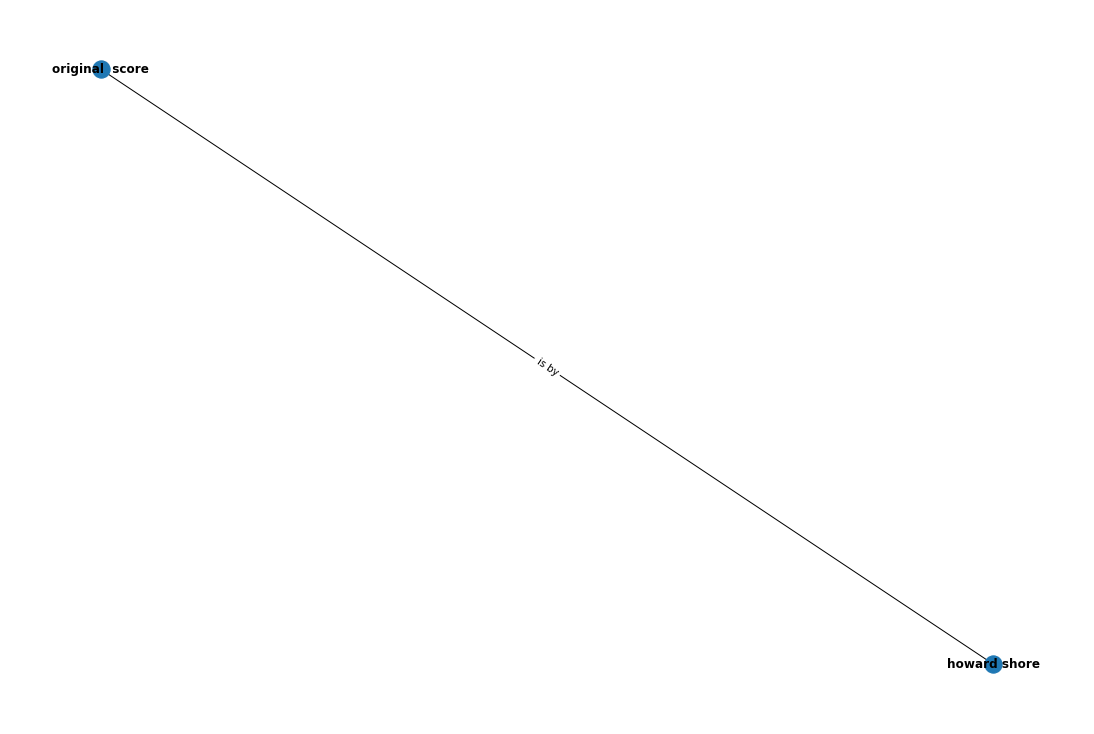

{('original  score', 'howard shore'): 'is by'}

In [90]:
# Lets draw a simple graph from 1 output
data = kg_df.sample(1)

g = nx.Graph()
g.add_weighted_edges_from([(data['source'].iloc[0], data['target'].iloc[0], 1)])
# E = [('A', 'B', 2), ('A', 'C', 1),('B', 'D', 5), ('B', 'E', 3)]
# g.add_weighted_edges_from(E)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(g)
nx.draw(g, pos, with_labels=True, font_weight='bold')
edge_weight = nx.get_edge_attributes(g, 'weight')
edge_weight[data['source'].iloc[0], data['target'].iloc[0]] = data['edge'].iloc[0]
nx.draw_networkx_edge_labels(g, pos, edge_labels = edge_weight)
plt.show()
edge_weight

In [48]:
G = nx.from_pandas_edgelist(kg_df, "source", "target", edge_attr=True, create_using=nx.MultiDiGraph()) 

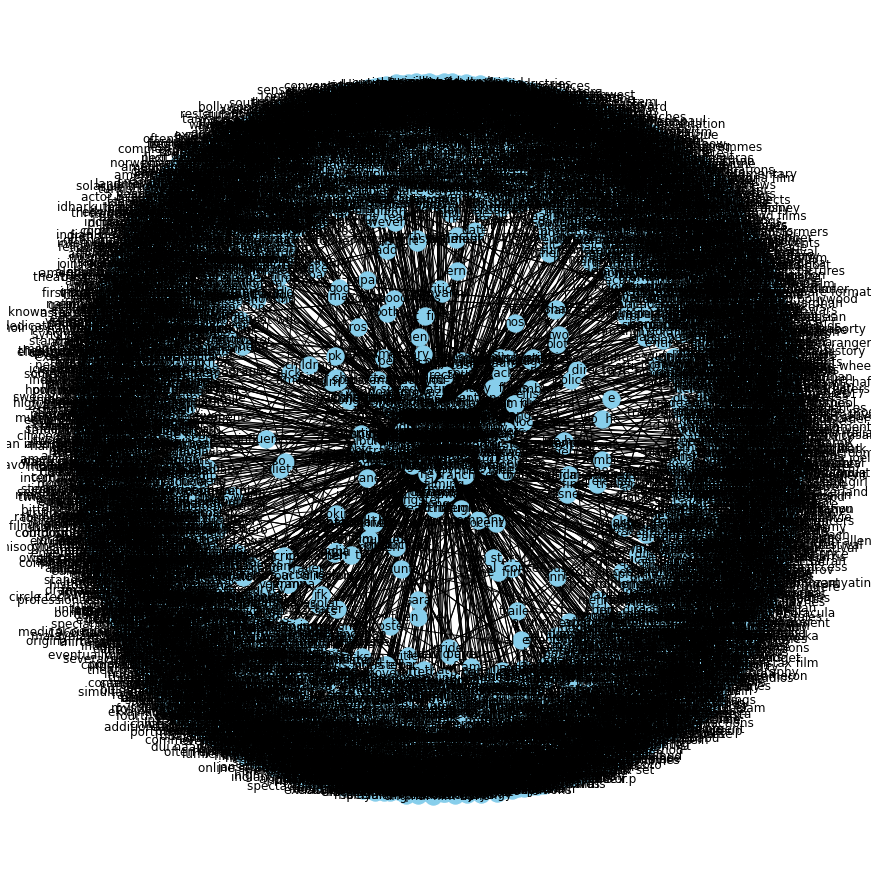

In [49]:
# Takes a while to render
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

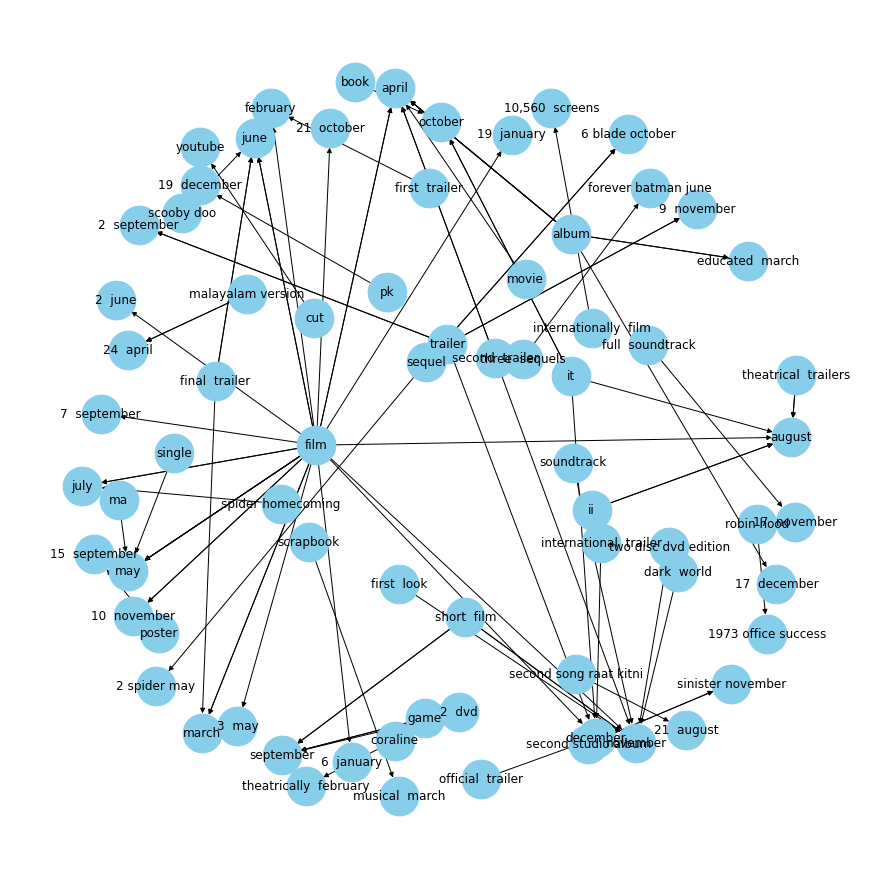

In [91]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released on"], "source", "target", edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()